For this first trial we assume a naive model (LGM) defined as:
$$dx_t = \sigma_t dW_t^{\mathit{N}}$$

Let's define the Numeraire as:
$$N(t, x_t) = \frac{1}{B(0,t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where $H_t$ and $\zeta_t$ are known functions.

With this let's defined the fundamental equation for the pricing of a derivative under the model. The NPV (Net Present Value) is:
$$V_t = V(t, x_t)$$ 
and the deflated version 
$$\overline{V}_t = V(t, x_t) / N(t, x_t)$$

#### Montecarlo simulation

* Brownian path:
$$W_t \sim \mathcal{N}(0,t)$$
$$W[0] = X_0$$
$$W[t] = W[t - 1]  + \mathcal{Z} \cdot \Delta t^{\frac{1}{2}}$$
with 
$$\mathcal{Z} \sim \mathcal{N}(0,1)$$
* X:
$$X_{t + 1} = X_t + \sigma \cdot (W_{t + 1} - W_t)$$

In [99]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from utils.simulator.simulator import MCSimulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
# Strike value
Vt = 2
T = 8
# Set of parameters
T, N_steps, X0, sigma = (T, 100, 0, 0.01)
mcsimulator = MCSimulation(T, N_steps, X0, sigma)
nsims = int(1e3)
test_sims = int(nsims * 0.2)
# Training
mc_paths, W = mcsimulator.simulate(nsims)
mc_paths_transpose = mc_paths.T
mc_paths_flatten = mc_paths.flatten('C')
w_paths_flatten = W.flatten('C')
# Test
mc_paths_test, W_test = mcsimulator.simulate(test_sims)
mc_paths_test_transpose = mc_paths_test.T
mc_paths_test_flatten = mc_paths_test.flatten('C')
w_paths_test_flatten = W_test.flatten('C')
# Deltas
deltaTs = np.linspace(0, T, N_steps)
simulations = np.linspace(0, nsims - 1, nsims)
simulations = np.int32(np.tile(simulations, N_steps))
deltaTs = np.tile(deltaTs.reshape(N_steps, 1), nsims).flatten()
df_x = pd.DataFrame(zip(
    deltaTs,
    mc_paths_flatten,
    w_paths_flatten,
    simulations
), columns = ['dt',
              'xt',
              'wt',
              'simulation'])

#### Visualization

In [137]:
deltaTs = np.linspace(0, T, N_steps)

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
if nsims < 101:
    plt.figure(figsize = (15,6))
    plt.title('Complete set of paths')
    sns.lineplot(x = 'dt', y = 'xt', hue = 'simulation', data = df_x)
    plt.show()
    plt.figure(figsize = (15,6))
    plt.title('Complete paths distribution')
    sns.regplot(x = 'dt', y = 'xt', data = df_x, scatter = False)
    plt.show()

#### Sanity with zero bond coupon

Numeraire: 

$$N(t, x_t) = \frac{1}{D(t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where:
* $D(t)$ given and follows = $D(t) = e^{-rt}$, in this example with $r = 0.03$
* $H(t) = \frac{1 - e^{-\kappa t}}{\kappa}$, with $\kappa = 2$

Discount factor (bono cupón 0 que paga 1 en T):

$$Z(x_t, t, T) = \frac{D(T)}{D(t)}exp-((H_T - H_t)x_t - \frac{1}{2}(H_T^2-H_t^2)\zeta_t) = \frac{D(T)}{D(t)}exp(-(H_T - H_t)x_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = $$
$$\frac{D(T)}{D(t)}exp(-H_Tx_t + H_tx_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = \frac{D(T)}{D(t)}exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)exp(H_tx_t + \frac{1}{2}H_t^2\zeta_t) = $$
$$D(T)exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)N(t, x_t)$$
where:
* $\zeta(t) = \int_0^t\sigma^2(s)ds$, with $\sigma(s)$ a piecewise function.

The sanity aims to retrieve the $D(t)$ after aggregating for each time step $t$ on the previous simulations. Steps:
* Calculate $Z(\cdot)$ for each timestep
* Calculate the numeraire $N(\cdot)$
* Get the $\hat{D}(t)$ for each path and time step as $\hat{D}(t) = \frac{Z(\cdot)}{N(\cdot)} \to E[\hat{D}(t)] = D(t)E[exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)] = D(T)exp(E[-\frac{1}{2}H_T^2\zeta_t-H_Tx_t]) = D(T)$
* Aggregate and compare the value with the theoretical $D(t)$

The final objective is to check that $E[-\frac{1}{2}H_T^2\zeta_t-H_Tx_t] = 0$

NOTE: $E[-\frac{1}{2}H_T^2\zeta_t-H_Tx_t] = -\frac{1}{2}H_T^2\zeta_t-H_TE[x_t]$

In [139]:
from utils.utils.utils import FinanceUtils, ZeroBound
t_unique = df_x.dt.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma_value = sigma) for dt in t_unique}
df_x['ct'] = df_x.apply(lambda x: dict_C[x['dt']], axis = 1)
xt, t, T, ct = df_x.xt, df_x.dt, T, df_x.ct
df_x['d_hat_t'] = ZeroBound.Z(xt, t, T, ct) / ZeroBound.N(t, xt, ct)
df_x['d_hat_tensor_t'] = ZeroBound.Z_tensor(xt, t, T, ct) / ZeroBound.N_tensor(t, xt, ct)
df_x['exponent'] = ZeroBound.exponent(xt, t, T, ct)
sanity = df_x.groupby(['dt']).agg(
    d_hat_t = ('d_hat_t', 'mean'),
    d_hat_tensor_t = ('d_hat_tensor_t','mean')
).reset_index()
sanity['dts'] = ZeroBound.D(np.array(sorted(t_unique)))
print(f'Expected exponent: {df_x.exponent.mean()}')

Expected exponent: 1.0000339783765995


In [140]:
t_unique = df_x.dt.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma_value = sigma) for dt in t_unique}

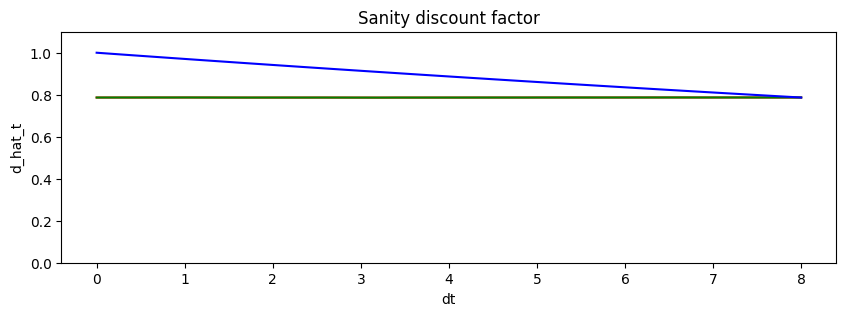

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10,3))
plt.title('Sanity discount factor')
sns.lineplot(x = 'dt', y = 'd_hat_t', data = sanity, color = 'red')
sns.lineplot(x = 'dt', y = 'd_hat_tensor_t', data = sanity, color = 'green')
sns.lineplot(x = 'dt', y = 'dts', data = sanity, color = 'blue')
plt.ylim(0, 1.1)
plt.show()

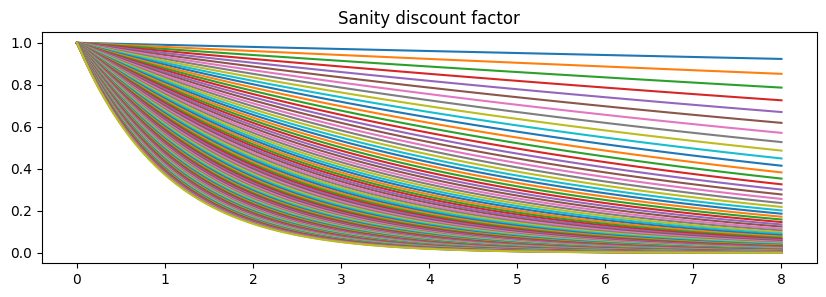

In [142]:
plt.figure(figsize = (10,3))
plt.title('Sanity discount factor')
for r in np.arange(0.01, 1.0, step = 0.01):
    sns.lineplot(x = t_unique, y = ZeroBound.D(np.array(sorted(t_unique)), r = r))
plt.show()

#### Seq2seq with feed forward neural networks

Check:
* https://towardsdatascience.com/how-to-use-custom-losses-with-custom-gradients-in-tensorflow-with-keras-e87f19d13bd5
* https://www.tensorflow.org/guide/autodiff

Current approaches:
* Traditional feed forward with two features as input features:
    * x_t - brownian path simulated
    * t - temporal instant 
    * The problem I see here is that we lose the $\frac{\delta \overline{V}_i}{\delta x_i}$, since the network is unique, thus we have: $\frac{\delta \overline{V}}{\delta x}(x_i)$
* Sequence models based:
    * The good part of this approach is $\mathcal{J} = (\nabla f_1,\dots, \nabla f_T)$ is a diagonal matrix. Since $f_i$ does not depend on $x_{j}, i \neq j$. Therefore, getting the gradients from the NN is much easier.

The idea is to include in the loss function the gradient tape to respect the model!!

In [143]:
# Tf imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

keras.backend.clear_session() 
keras.backend.set_floatx('float64')
tf.executing_eagerly()

True

#### Iterative process
* F - neural network function.
* $\frac{\delta F}{\delta X_t}^i$ - gradient calculated by using the model at $i$-iteration.
* $\phi(n, x_n)$ - known terminal function.


**Path generation**

Theoretical:
$$\overline{V}_t = V(t, x_t) / N(t, x_t)$$
$$\overline{V}_{t+1} = \overline{V}_t + \frac{\delta V(t)}{\delta x_t}(x_{t + 1} - x_{t})$$
with $\phi(x_T, T) = \overline{V}_T$ known.

With NN
$$\hat{V} = F(X)$$

$$\overline{V}_{t+1} = Pred_t + \frac{\delta F(X)}{\delta x_t}(x_{t + 1} - x_{t})$$

**Loss function**
$$\mathcal{L}(\overline{V}) = \beta_1 \cdot (\overline{V}_T - \phi(T, x_T))^2 + \beta_2\cdot (\frac{\delta NN_T}{\delta x_T} - \frac{\delta \phi(T, x_T)}{\delta x_T})^2 + \beta_3\sum_{i = 1}^{T - 1}(\overline{V}_i - Pred_i)^2$$

This loss function has a problem when the architecture is single step at a time, that is $F(x,t) \in R^{2,1}$. The problem is that for each path of length $N$ produce only one single error loss. Nevertheless, we can overcome this by defining the error as a triangular inferior matrix per sample as:

Monte Carlo (Deep RL) approach:

$$
\mathcal{L}_{stepsLoss} = \beta_3\cdot\begin{pmatrix}
 0. \\
 0. \\ 
 \dots \\
 \dots \\ 
 \sum_{i = 0}^{N-1}(\overline{V}_{i} - Pred_{i})^2
\end{pmatrix}
$$

$$
\mathcal{L}_{stepsLoss} = \beta_3\cdot\begin{pmatrix}
(\overline{V}_{0} - Pred_{0})^2& \dots & 0 & 0 \\
(\overline{V}_{0} - Pred_{0})^2 & \sum_{i = 0}^{2}(\overline{V}_{i} - Pred_{i})^2 & \dots & 0 \\
 & & \dots & \\
(\overline{V}_{0} - Pred_{0})^2 & \sum_{i = 0}^{2}(\overline{V}_{i} - Pred_{i})^2 & \dots & \sum_{i = 0}^{N-1}(\overline{V}_{i} - Pred_{i})^2
\end{pmatrix}
$$
After taking the `diag`

$$
\mathcal{L}_{stepsLoss} = \beta_3\cdot\begin{pmatrix}
(\overline{V}_{0} - Pred_{0})^2 \\
 \sum_{i = 0}^{2}(\overline{V}_{i} - Pred_{i})^2\\ 
 \dots\\
 \dots \\ \sum_{i = 0}^{N-1}(\overline{V}_{i} - Pred_{i})^2
\end{pmatrix}
$$

Option B:
$$
\mathcal{L}_{stepsLoss} = \beta_3\cdot\begin{pmatrix}
(\overline{V}_{0} - Pred_{0})^2 \\
 (\overline{V}_{1} - Pred_{1})^2\\ 
 \dots\\
 \dots \\ (\overline{V}_{N} - Pred_{N})^2
\end{pmatrix}
$$

$\phi(\cdot)$:
* Constant function $f(x, n) = 1$
* IRS - TODO: Check

Experiments:
* Terminal condition 1 - static case:
    * Train the network and do the sanity against the payoff for a Zero Bound Coupon $\overline{V}(x_t,t) = \frac{Z(t, x_t, T)}{N(x_t, t)}$
    * Second detail: The NN (predict vectorized) predicts the value $\overline{V}(x_t, t)$ which is our objective

### Single step model

In [144]:
from utils.utils.utils import MLUtils
dts = list(np.linspace(0, T, N_steps)) * len(mc_paths_transpose)
simulation = [
    [i] * N_steps for i in range(nsims)
]
df_x_tmp = pd.DataFrame(
    zip(
        mc_paths_transpose,
        simulation
    ),
    columns = [
        'path',
        'simulation'
    ]
)
df_x = pd.DataFrame()
df_x['xt'] = df_x_tmp.explode('path')['path']
df_x['dt'] = dts
df_x['simulation'] = df_x_tmp.explode('simulation')['simulation']
df_x['_delta_x'] = df_x.groupby([
    'simulation',
])['xt'].shift(1)
df_x['_delta_x'] = (df_x['xt'] - df_x['_delta_x'])
df_x.loc[df_x._delta_x.isna(), '_delta_x'] = 0.
# Sort to get the examples in blocks
df_x.sort_values(
    [
        'simulation',
        'dt'
    ],
    inplace = True
)

Features shape: (100000, 2)
Batch size: 100 paths per epoch with length 100
T: 8
Positions to avoid from V 100.0
Positions to complete from V 100.0
Model: "LGM_NN_model_single_step"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_nn (InputLayer)       [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)          

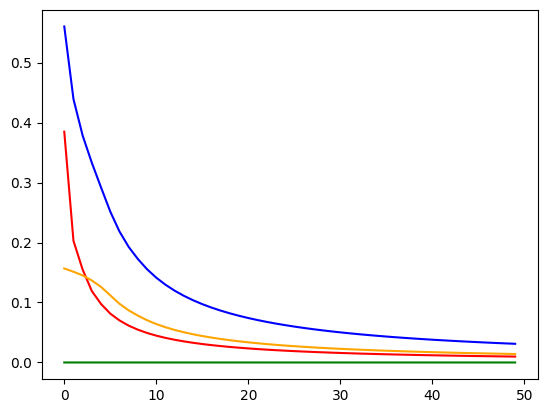

In [145]:
import time
import sys
from model.model_lgm_single_step import LGM_model_one_step

epochs = 50
mc_paths_tranformed = df_x[['xt', 'dt']].values
# Data used as features
x = mc_paths_tranformed.astype(np.float64)
delta_x = df_x._delta_x.values.astype(np.float64)
print(f'Features shape: {x.shape}')
# Batch execution with baby steps
size_of_the_batch = 100
batch_size = size_of_the_batch * N_steps
batches = int(np.floor(nsims * N_steps / batch_size))
print(f'Batch size: {size_of_the_batch} paths per epoch with length {N_steps}')
# Custom model
lgm_single_step = LGM_model_one_step(n_steps = N_steps, 
                                     T = T, 
                                     verbose = False,
                                     sigma = sigma,
                                     batch_size = size_of_the_batch,
                                     phi = ZeroBound.Z_normalized)
print(f'{lgm_single_step.summary()}')
# Compile the model
lgm_single_step.define_compiler(optimizer = 'adam', learning_rate = 1e-3)
# Losses:
losses_split = {
    'total': [],
    'strike_loss': [],
    'strike_derivative_loss': [],
    'steps_error': []
}
# Custom iteration: 
start_time = time.time()
for epoch in range(epochs):
    print(f'{epoch}...', end = '')
    dimension = (1, batches)
    total_tmp, strike_tmp, derivative_tmp, steps_tmp = (
        np.zeros(dimension),
        np.zeros(dimension),
        np.zeros(dimension),
        np.zeros(dimension)
    )
    for batch in range(batches):
        x_batch = x[batch * batch_size: (batch + 1) * batch_size, :]
        delta_x_batch = delta_x[batch * batch_size: (batch + 1) * batch_size]
        el, sl, sdl, se = lgm_single_step.custom_train_step(
            X = x_batch,
            batch = batch,
            epoch = epoch, 
            start_time = start_time,
            delta_x = delta_x_batch)
        # Store partial results
        total_tmp[0, batch] = el
        strike_tmp[0, batch] = sl
        derivative_tmp[0, batch] = sdl
        steps_tmp[0, batch] = se
    losses_split['total'].append(
        el
    )
    losses_split['strike_loss'].append(
        sl
    )
    losses_split['strike_derivative_loss'].append(
        sdl
    )
    losses_split['steps_error'].append(
        se
    )
# Visualize errors
plt.figure()
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['total'], 
             color = 'blue')
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['strike_loss'],
             color = 'red')
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['strike_derivative_loss'],
             color = 'orange')
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['steps_error'],
             color = 'green')
plt.show()

#### Sanity the NN

Once again we use the analytical solution for a ***Zero Coupon Bond***:

Numeraire: 

$$N(t, x_t) = \frac{1}{D(t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where:
* $D(t)$ given and follows = $D(t) = e^{-rt}$, in this example with $r = 0.03$
* $H(t) = \frac{1 - e^{-\kappa t}}{\kappa}$, with $\kappa = 2$

Discount factor (bono cupón 0 que paga 1 en T):

$$Z(x_t, t, T) = \frac{D(T)}{D(t)}exp-((H_T - H_t)x_t - \frac{1}{2}(H_T^2-H_t^2)\zeta_t) = \frac{D(T)}{D(t)}exp(-(H_T - H_t)x_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = $$
$$\frac{D(T)}{D(t)}exp(-H_Tx_t + H_tx_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = \frac{D(T)}{D(t)}exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)exp(H_tx_t + \frac{1}{2}H_t^2\zeta_t) = $$
$$D(T)exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)N(t, x_t)$$
where:
* $\zeta(t) = \int_0^t\sigma^2(s)ds$, with $\sigma(s)$ a piecewise function.

But we are estimating $\overline{V}_t = \frac{Z(x_t, t, T)}{N(t, x_t)} = D(T)exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)$

* Single step network

In [146]:
dts = list(np.linspace(0, T, N_steps)) * len(mc_paths_test_transpose)
simulation = [
    [i] * N_steps for i in range(test_sims)
]
df_x_tmp = pd.DataFrame(
    zip(
        mc_paths_test_transpose,
        simulation
    ),
    columns = [
        'path',
        'simulation'
    ]
)
df_x = pd.DataFrame()
df_x['xt'] = df_x_tmp.explode('path')['path']
df_x['dt'] = dts
df_x['simulation'] = df_x_tmp.explode('simulation')['simulation']
df_x['_delta_x'] = df_x.groupby([
    'simulation',
])['xt'].shift(1)
df_x['_delta_x'] = (df_x['xt'] - df_x['_delta_x'])
df_x.loc[df_x._delta_x.isna(), '_delta_x'] = 0.
# Sort to get the examples in blocks
df_x.sort_values(
    [
        'simulation',
        'dt'
    ],
    inplace = True
)
# Adjust x
mc_paths_tranformed = df_x[['xt', 'dt']].values.astype(np.float64)
delta_x = df_x._delta_x.values.astype(np.float64)
# mc_paths_tranformed = np.reshape(mc_paths_tranformed, (N_steps * nsims, 2)).T
# Data used as features
x = mc_paths_tranformed.astype(np.float64)
x = tf.constant(x)
v_lgm_single_step, predictions = lgm_single_step.predict(x, 
                                                         delta_x,
                                                         build_masks = True)
# Adapt output
results = pd.DataFrame(
    zip(v_lgm_single_step),
    columns = ['results']
)
v_lgm_single_step = results.explode('results').values
df_x['lgm_single_step_V'] = v_lgm_single_step.astype(np.float64)
df_x.head()

,xt,dt,simulation,_delta_x,lgm_single_step_V
0,0.0,0.000000,0,0.0,0.786659
0,-0.002732,0.080808,0,-0.002732,0.787511
0,-0.004701,0.161616,0,-0.001969,0.788178
0,-0.008729,0.242424,0,-0.004028,0.789595
0,-0.012685,0.323232,0,-0.003956,0.791037


In [147]:
v_df = pd.DataFrame(
    zip(df_x.lgm_single_step_V.values,
        df_x.dt.values, 
        df_x.xt.values,
        df_x.simulation.values), 
    columns = ['V_hat_single_step', 
               'deltat', 
               'xt',
               'simulation'])
t_unique = v_df.deltat.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma_value = sigma) for dt in t_unique}
v_df['ct'] = v_df.apply(lambda x: dict_C[x['deltat']], axis = 1)
v_df.head()

,V_hat_single_step,deltat,xt,simulation,ct
0,0.786659,0.000000,0.000000,0,0.000000
1,0.787511,0.080808,-0.002732,0,0.000008
2,0.788178,0.161616,-0.004701,0,0.000016
3,0.789595,0.242424,-0.008729,0,0.000024
4,0.791037,0.323232,-0.012685,0,0.000032


In [148]:
# Z value
print(f'Calculating V')
v_df['Z'] = v_df.apply(
    lambda x: 
        ZeroBound.Z(x.xt, x.deltat, T, x.ct), 
        axis = 1)
# Getting N
print(f'Getting N')
v_df['N'] = v_df.apply(
    lambda x: 
        ZeroBound.N(x.deltat, x.xt, x.ct), 
        axis = 1)
# Getting V
v_df['V'] = v_df.Z / v_df.N

Calculating V
Getting N


In [149]:
v_df[['N', 'Z', 'V', 'V_hat_single_step', 'simulation', 'deltat']]

,N,Z,V,V_hat_single_step,simulation,deltat
0,1.000000,0.786628,0.786628,0.786659,0,0.000000
1,1.002223,0.789453,0.787702,0.787511,0,0.080808
2,1.004208,0.791795,0.788477,0.788178,0,0.161616
3,1.005612,0.794500,0.790066,0.789595,0,0.242424
4,1.006701,0.796934,0.791630,0.791037,0,0.323232
...,...,...,...,...,...,...
19995,1.242201,0.990350,0.797254,0.798076,199,7.676768
19996,1.245312,0.992754,0.797193,0.798029,199,7.757576
19997,1.244825,0.995163,0.799441,0.800259,199,7.838384
19998,1.248245,0.997579,0.799185,0.800021,199,7.919192


In [152]:
condition = (v_df.deltat == T)
v_strike_loss = v_df.loc[
    condition
]
print(f'Strike error: {np.sqrt(np.mean((v_strike_loss.V - v_strike_loss.V_hat_single_step)**2))}')

Strike error: 0.0008732171006765477


In [153]:
v_strike_loss[['V', 'V_hat_single_step']]

,V,V_hat_single_step
99,0.788144,0.789082
199,0.779752,0.780654
299,0.781091,0.782005
399,0.792481,0.793403
499,0.789434,0.790370
...,...,...
19599,0.784295,0.785228
19699,0.785732,0.786669
19799,0.778968,0.779862
19899,0.800218,0.801052


In [154]:
error = np.mean(np.abs(v_df.V_hat_single_step - v_df.V))
print(f'Absolute error: {error}')

Absolute error: 0.0005130682404924669


In [155]:
trajectory_predicted = v_df.V_hat_single_step.astype(np.float64).values.reshape((test_sims, N_steps))
trajectory_real = v_df.V.values.reshape((test_sims, N_steps))

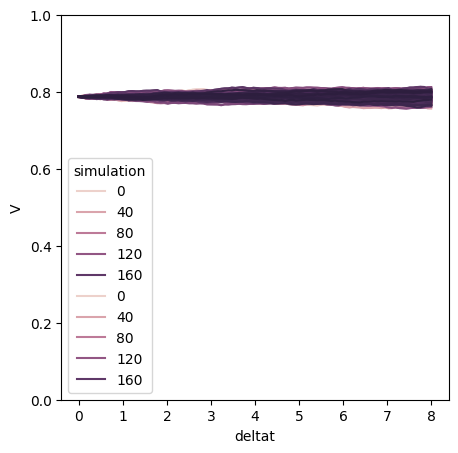

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (5, 5))
sns.lineplot(
    x = 'deltat',
    y = 'V',
    color = 'red',
    hue = 'simulation',
    data = v_df
)
sns.lineplot(
    x = 'deltat',
    y = 'V_hat_single_step',
    color = 'blue',
    hue = 'simulation',
    data = v_df
)
plt.ylim(0, 1)
plt.show()